In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,7)

## Step 0
### Data Acquisition

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"]  # type: ignore

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
# rets

## Step 2

### Describe the complete pair strategy adopted, composed of: (a) a baseline strategy based on the co-integrated spread of the chosen ETF pair trade, and (b) an added volatility regime-switching indicator, that activates the baseline strategy only when within the low-volatility regime.

The pair trading strategy illustrated in this report consists identifying ETFs belonging to the same economic sector, covering similar assets and replicating similar indices.
These ETFs should theoretically respond in a synchronised way to the vagaries of the markets.

In the jargon of Econometrics, this observation can be associated with the concept of two time series being *cointegrated*.
Cointegration is a more stringent condition than correlation: it prescribes the series do not just move with the same trend, but also keep their distance (difference of values at the same position in the time series) within a certain band.
Given this definition, it seems then logical to associate cointegration with the notion of mean-reversion of a time series, and hence, to its stationarity.
In literature, there exist six statistical tests that can be performed on a pair of time series, to verify whether they are co-integrated.

In this report, we have resorted to the Engle-Granger test in previous section 1.b, to check for cointegration of three pairs of ETFs, belonging to the energy, gold and technology sectors.
This test regresses one of the series, using the other one as exogenous variable.
The residuals of the linear regression are then checked for stationarity, which is attained in the absence of unit roots.
The stationarity test we used in the previous section is the augmented Dickey-Fuller test, which rejects the null hypothesis of non-stationarity if the $p$-value of the associated Dickey-Fuller statistic is $< 0.05$.
Success of the ADF test on the residuals of the regression (spread) also allows to define the two original time series as cointegrated in the Engle-Granger sense. 

A pair trading strategy based on two cointegrated price series would exploit the expected stationarity, hence mean reversion of their spread, in case their spread on the markets strays outside of the expected band of mean reversion, breaching either the negative or the positive threshold.
This is seen as an anomaly for cointegrated time series, that should quickly retreat back within the accepted band of mean reversion for the series spread.

However, like correlation, cointegration between assets might radically break down and reconfigure in times of economic crisis.
In section 1c, we have identified two volatility regimes within the financial markets, based on the evolution of SPY for the period 2017-22.

Here, we upgrade the pair trading strategy already sketched in section 1b, with an additional indicator of high-volatility regime in the markets.
When we enter a period of high volatility in the markets, that could potentially turn into a fully fledged crisis where our pair cointegration might break down, the indicator activates.
The pair strategy is then directed to relinquish taking any position in the two ETFs composing the pair, until the high-volatility regime subsumes.

This expedient helps the strategy to avoid investing in periods when the cointegration relation, which lies at the basis of pair trading, might not hold, and thus the original vanilla pair strategy would be no better than random betting on the markets, and would result in realised looses.

#### Description of the volatility regime-switching indicator

Here we employ code and results from section 1.c to construct the volatility-regime-switching indicator.

From that section, we know that the Markov switching regression model is built on python with the `MarkovAutoregression` class in statsmodels.
The class is fed initial state and boundary limits to its inner optimisation algorithm from observation of the time series of SPY during the timeframe of reference, as already described in section 1.c.

The class can output the smoothed probabilities for each regime to happen during the timeframe.
*Smoothed*, as opposed to *filtered* probabilities are computed for each time point $t$ using a larger number of neighbouring points, hence giving a more regular appearance than filtered probabilities, which are more locally restricted.

Our high volatility regime-switching indicator $I_{h \sigma}$ is derived from the smoothed probabilities of high volatility, $p_{h \sigma,\,\text{smooth}}$, by switching on the signal when smoothed probabilities of high vol are $p_{h \sigma,\,\text{smooth}} \geq 0.9$.

$$
I_{h \sigma} = \begin{cases}
    1 & p_{h \sigma,\,\text{smooth}} \geq 0.9\\
	0 & p_{h \sigma,\,\text{smooth}} < 0.9
\end{cases}
$$

We plot $I_{h \sigma}$ in the graph below.

In [3]:
# b add volatility-switch indicator to the strategy
# from step 1c
mod_spy = sm.tsa.MarkovAutoregression(rets["SPY"], k_regimes=2, order=1, trend='c', switching_ar=True, switching_variance=True)

# halflife
tau_days = np.array([10.5, 21]) # SPY returns half-revert in 10 days when low vol, in 21 when high vol
business_year_in_days = 252
tau = tau_days / business_year_in_days
# UO's mean reversion adapted to AR(1)'s beta
log2 = np.log(2)
kappa = log2 / tau
beta = np.exp(-kappa / business_year_in_days)

mu = [0.0005, -0.0010]
alpha = mu * (1 - beta)

sigma = [0.008, 0.02]

# rough estimation of logit^-1(transition probabilities)
P = np.array([0.9, 0.5])
logit = np.exp(P)/(1 + np.exp(P))

start = mod_spy.start_params.copy()
start[:2] = logit       # logit(P)       # mu guesses: calm 20 bp, stress 200 bp
start[2:4] = alpha  # mu          # beta guesses: kappa approx 2.3 /yr vs 1.0 /yr
start[4:6] = np.square(sigma)           # sigma guesses
# logit(P00) ~ 2.5  -> P00 approx 0.92 ; logit(P11) ~ 0   -> P11 approx 0.5
start[6:8] = beta  # beta

# bounds:   alpha ≥ 0,   0.70 <= beta <= 0.95,   sigma ≥ 1e‑3,   transition logits free
b = [(0.25, 0.931), (0.25, 0.931), #(0.5, 0.731), (0.5, 0.731), # P         # mu
	(-0.001, 0.1), (-0.001, 0.1), #(-0.01, 0.01), (-0.01, 0.01), # mu   # beta
	(1e-3, 1e6), (1e-3, 1e6),    # sigma
	(0.50, 1.3), (0.50, 1.3)]  #beta  # logits of P

np.random.seed(1234)
spy_markov_results = mod_spy.fit(start_params=start, bounds=b, method="bfgs", maxiter=500, search_reps=20)

In [4]:
# high vol regime indicator to be used inside pair strategy
switch_high_vol = spy_markov_results.smoothed_marginal_probabilities[0] > 0.9
# switch_high_vol 

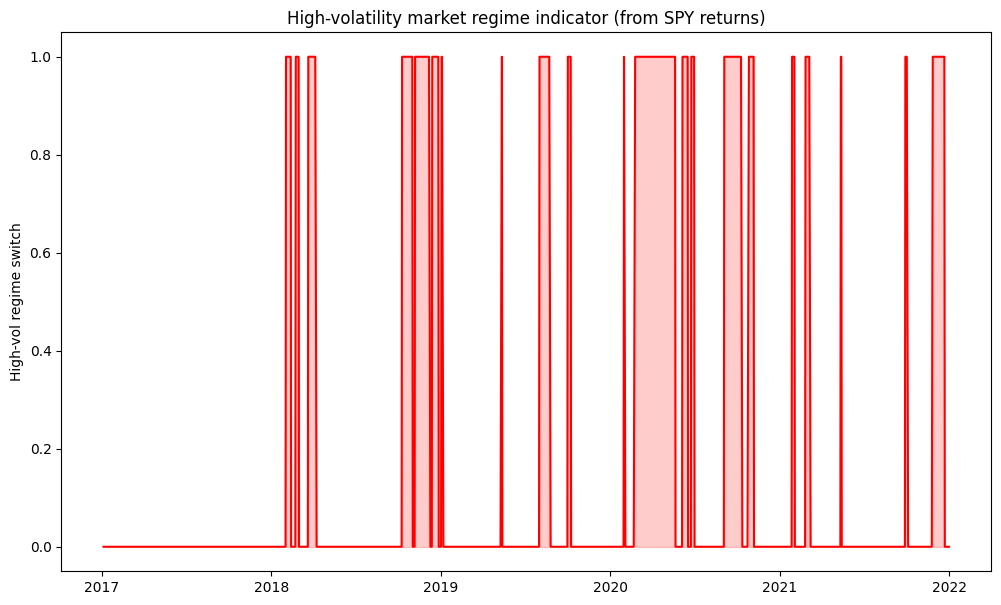

In [5]:
#fig, axes = plt.subplots(2)

# ax = axes[0]
# ax.plot(spy_markov_results.smoothed_marginal_probabilities[1],'g')
# ax.set(title="Probability of a low-volatility regime for SPY returns")

plt.plot(switch_high_vol,'r')
plt.fill_between(switch_high_vol.index, 0, 1, where=switch_high_vol.values == 1, color="r", alpha=0.2)
plt.title("High-volatility market regime indicator (from SPY returns)")
plt.ylabel("High-vol regime switch")
plt.show()

We note here that by both

- adopting as indicator the high volatility regime, instead of the low volatility one, and
- setting a high threshold at $0.9$ for indicator activation,

we create a more aggressive investment strategy, as this limits the trading stop only to instances of very high volatility regime.

Choosing to operate the pair strategy only under low volatility regimes, instead of directly excluding operations during high volatility bouts, would have led to a more defensive strategy.
Same can be said if we were still to employ the high volatility indicator, but with a lower threshold of activation.

We now apply the vol regime-switching pair strategy just described, to the three pairs of ETFs belonging to the sectors of Energy, Gold, and Technology.

#### Strategy 1: Energy ETFs

The vanilla strategies will differ from those sketched in section 1.b, in that the condition to exit positions is no more triggered by

$$
\left| z_{\text{spread}} \right| < 0.5
$$

that is, the $z$-score of pair spread $z_{\text{spread}}$ should lay in a band $\pm 0.5$ around $0$.

Now, the $z$-score will have to lie in a tighter band $\pm 0.1$ around $0$, and in addition a trade will be exited when the $z$-score of pair spread changes sign from the previous observation:

\begin{aligned}
    z_{\text{spread}}(t) \cdot z_{\text{spread}}(t-1) & < & 0\\	
	\left| z_{\text{spread}} \right| & < & 0.1
\end{aligned}

The long and short trading thresholds stay the same, respectively:

\begin{cases}
    z_{\text{spread}}  \leq -2 & \text{enter long}\\	
	z_{\text{spread}}  \geq 2 & \text{enter short}
\end{cases}

In [6]:
# OLS regression and spread
y = prices["XLE"]
X = sm.add_constant(prices["XOP"])
model_energy = sm.OLS(y, X).fit()
alpha_energy, beta_energy = model_energy.params
spread_energy = y - (alpha_energy + beta_energy * prices["XOP"])
spread_energy.name = "Spread"
# print("XLE on XOP Regression beta coefficient: ", beta_energy)

In [7]:
# a. baseline strategy
roll_window = 63 # trimestral
zscore_energy = (spread_energy - spread_energy.rolling(roll_window).mean()) / spread_energy.rolling(roll_window).std()
long_entry  = zscore_energy <= -2
short_entry = zscore_energy >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_energy) != np.sign(zscore_energy.shift()) #or (zscore_energy.abs() < 0.1) #zscore_energy.abs() < 0.5
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_energy.abs() < 0.1)

position_energy_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_energy_no_switch = pd.Series(position_energy_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_energy_no_switch = position_energy_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy_no_switch.name = "Spread Position"
# position_energy

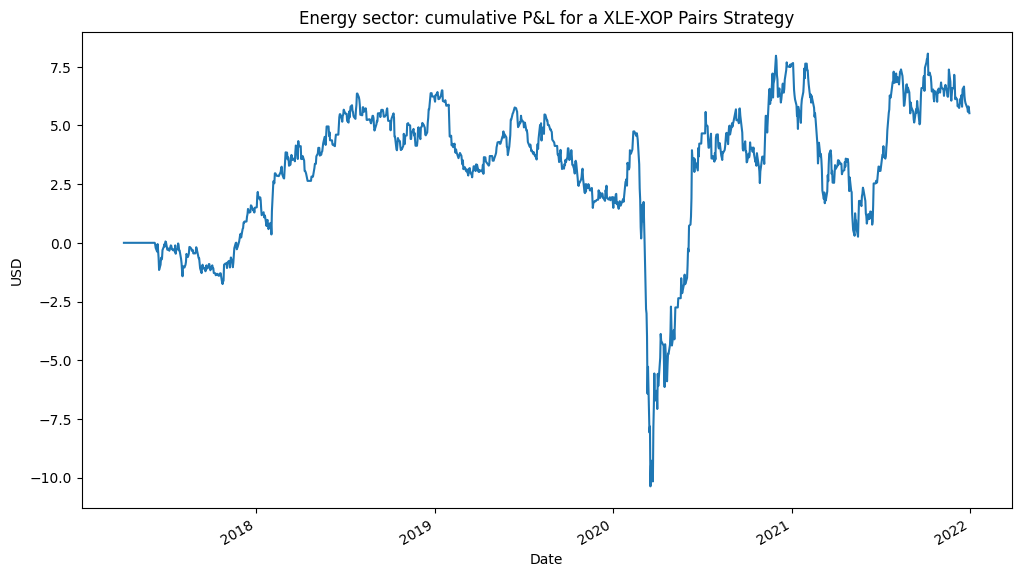

Annualised Sharpe for Energy sector pair strategy ≈ 0.19


In [8]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy_no_switch.shift() * spread_returns
cum_pnl_energy_no_switch = strategy_ret.cumsum()
cum_pnl_energy_no_switch.name = "PnL Energy pair"

# Results
fig, ax = plt.subplots()
cum_pnl_energy_no_switch.plot(ax=ax, title="Energy sector: cumulative P&L for a XLE-XOP Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_energy_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy_no_switch:.2f}")

With the new exit trade condition, the annualised Sharpe ratio grows to $0.19$ from $0.09$ in section 1.b.

In the following, we derive the pair strategy with added regime switching indicator.

In [9]:
# apply vol switch to trading strategy 
position_energy_with_switch = position_energy_no_switch.where(~switch_high_vol, 0)

#position_energy_with_switch = position_energy_with_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy_with_switch.name = "Spread Position"
# position_energy_with_switch

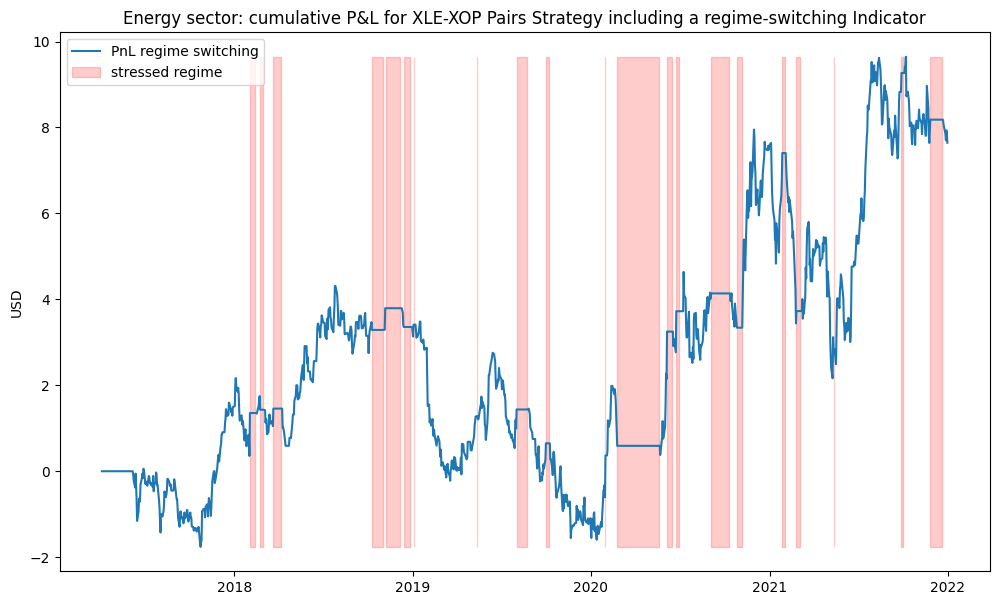

Annualised Sharpe for Energy sector pair strategy ≈ 0.39


In [10]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy_with_switch.shift() * spread_returns
cum_pnl_energy_with_switch = strategy_ret.cumsum()
cum_pnl_energy_with_switch.name = "PnL Energy pair"

min_pnl = cum_pnl_energy_with_switch.min()
max_pnl = cum_pnl_energy_with_switch.max()
# Results
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Energy sector: cumulative P&L for XLE-XOP Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_energy_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy_with_switch:.2f}")

We observe the regime switching indicator to be a beneficial add-on to the pair strategy, increasing the annualise Sharpe ratio from $0.19$ to $0.39$.

We aggregate the vanilla and the regime switching strategy in the graph below for comparison.

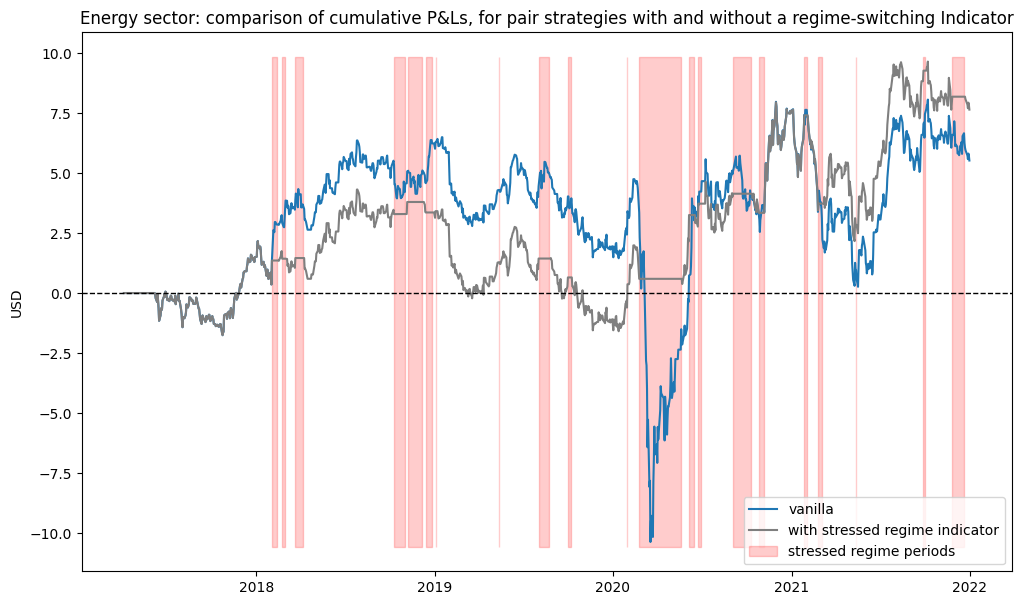

In [11]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_energy_with_switch.min(), cum_pnl_energy_no_switch.min())
max_pnl = max(cum_pnl_energy_with_switch.max(), cum_pnl_energy_no_switch.max())

#plt.plot(cum_pnl_energy.index, cum_pnl_energy)
plt.plot(cum_pnl_energy_no_switch.index, cum_pnl_energy_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Energy sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="lower right")

plt.show()

It is remarkable that the improved pair strategy with indicator is able to completely avoid the big drawdown experienced by the vanilla strategy in the first quarter of 2020.

#### Strategy 2: Gold ETFs

We apply the strategy to the Gold sector ETFs.

In [12]:
# OLS regression and spread
y = prices["GDX"]
X = sm.add_constant(prices["GLD"])
model_gold = sm.OLS(y, X).fit()
alpha_gold, beta_gold = model_gold.params
spread_gold = y - (alpha_gold + beta_gold * prices["GLD"])
spread_gold.name = "Spread"

In [13]:
# baseline strategy
roll_window = 63 # trimestral
zscore_gold = (spread_gold - spread_gold.rolling(roll_window).mean()) / spread_gold.rolling(roll_window).std()
long_entry  = zscore_gold <= -2
short_entry = zscore_gold >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_gold) != np.sign(zscore_gold.shift())
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_gold.abs() < 0.1)

position_gold_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_gold_no_switch = pd.Series(position_gold_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_gold_no_switch = position_gold_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_gold_no_switch.name = "Spread Position"
# position_gold

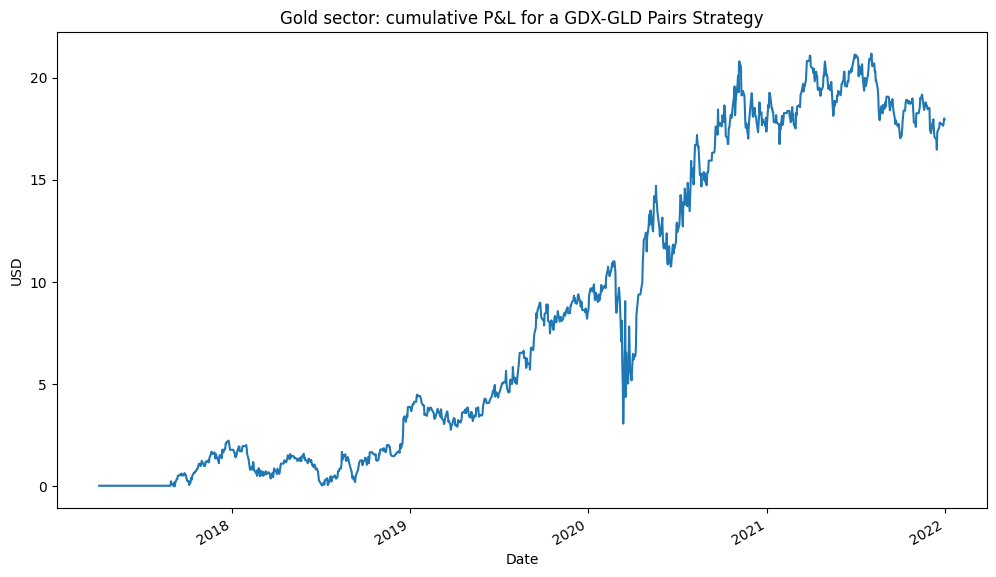

Annualised Sharpe for Gold sector pair strategy ≈ 0.61


In [14]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold_no_switch.shift() * spread_returns
cum_pnl_gold_no_switch = strategy_ret.cumsum()
cum_pnl_gold_no_switch.name = "PnL Gold pair"

# Results
fig, ax = plt.subplots()
cum_pnl_gold_no_switch.plot(ax=ax, title="Gold sector: cumulative P&L for a GDX-GLD Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_gold_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold_no_switch:.2f}")

The annualised Sharpe ratio of the vanilla strategy with updated exit condition is slightly less than that with the previous exit condition ($0.61$ vs $0.69$).

We remind that this was the most effortlessly cointegrated pair among the three considered.

In [15]:
# apply vol switch to trading strategy 
position_gold_with_switch = position_gold_no_switch.where(~switch_high_vol, 0)

position_gold_with_switch.name = "Spread Position"
# position_gold_with_switch

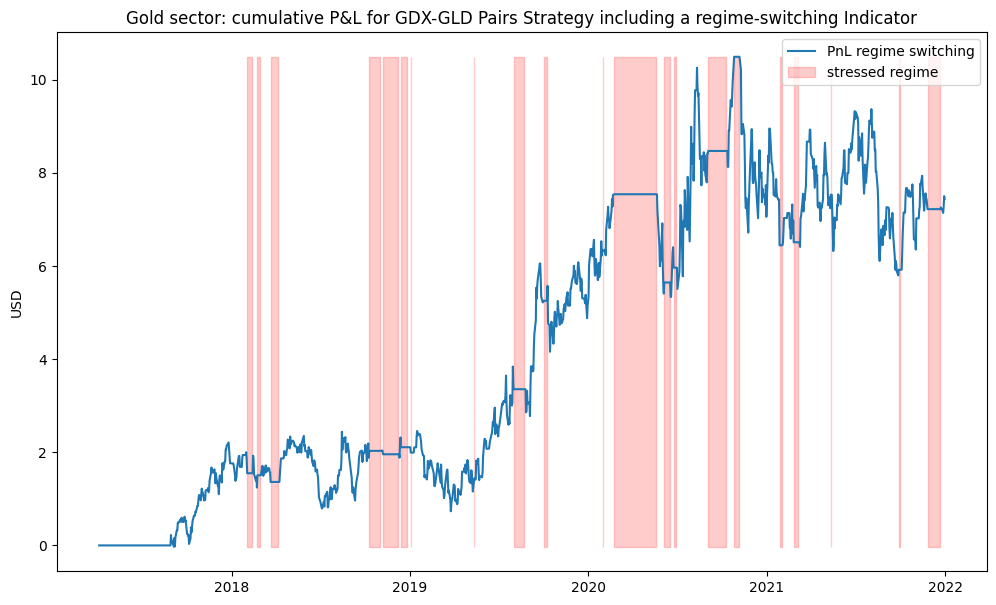

Annualised Sharpe for Gold sector pair strategy ≈ 0.40


In [16]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold_with_switch.shift() * spread_returns
cum_pnl_gold_with_switch = strategy_ret.cumsum()
cum_pnl_gold_with_switch.name = "PnL Gold pair"

min_pnl = cum_pnl_gold_with_switch.min()
max_pnl = cum_pnl_gold_with_switch.max()
# Results
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Gold sector: cumulative P&L for GDX-GLD Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_gold_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold_with_switch:.2f}")

The annualised Sharpe ratio of the regime switching strategy is more than $30 \%$ down with respect to the vanilla strategy.

This is readily explained by the fact that Gold is a refuge asset in times of crisis, and as a result the cointegrated ETFs did not in fact lose much money during the Covid 2020 crisis.
The improved pair strategy, by virtue of stopping to trade during high volatility times, unwittingly foregoes the profits made by this refuge asset in the immediate afterward of such junctures.

This is visible if we superimpose profits from the vanilla and from the regime switching pair strategies:

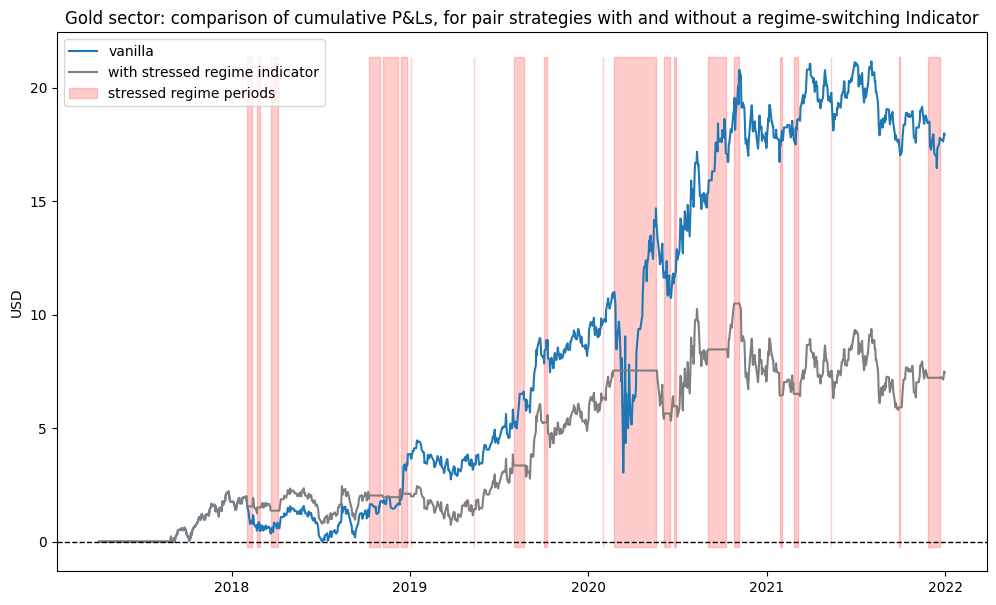

In [17]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_gold_with_switch.min(), cum_pnl_gold_no_switch.min())
max_pnl = max(cum_pnl_gold_with_switch.max(), cum_pnl_gold_no_switch.max())

plt.plot(cum_pnl_gold_no_switch.index, cum_pnl_gold_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Gold sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="upper left")

plt.show()

#### Strategy 3: Technology ETFs

Lastly, the technology ETFs.

In [18]:
# OLS regression and spread
y = prices["IYW"]
X = sm.add_constant(prices["XLK"])
model_tech = sm.OLS(y, X).fit()
alpha_tech, beta_tech = model_tech.params
spread_tech = y - (alpha_tech + beta_tech * prices["XLK"])
spread_tech.name = "Spread"

In [19]:
# baseline strategy
roll_window = 63 # trimestral
zscore_tech = (spread_tech - spread_tech.rolling(roll_window).mean()) / spread_tech.rolling(roll_window).std()
long_entry  = zscore_tech <= -2
short_entry = zscore_tech >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_tech) != np.sign(zscore_tech.shift())
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_tech.abs() < 0.1)

position_tech_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_tech_no_switch = pd.Series(position_tech_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_tech_no_switch = position_tech_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_tech_no_switch.name = "Spread Position"
# position_tech

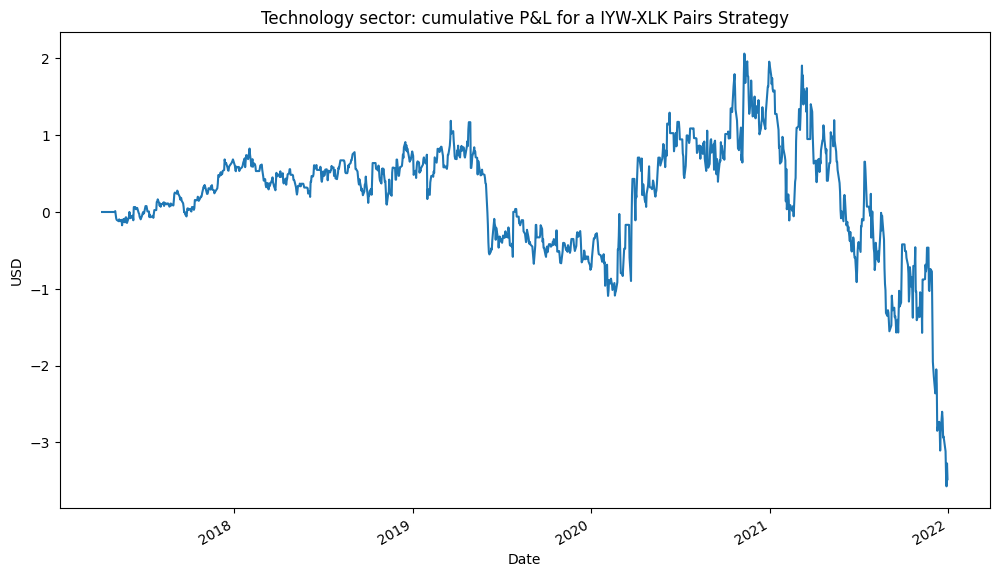

Annualised Sharpe for Technology sector pair strategy ≈ -0.31


In [20]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech_no_switch.shift() * spread_returns
cum_pnl_tech_no_switch = strategy_ret.cumsum()
cum_pnl_tech_no_switch.name = "PnL Technology pair"

# Results
fig, ax = plt.subplots()
cum_pnl_tech_no_switch.plot(ax=ax, title="Technology sector: cumulative P&L for a IYW-XLK Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_tech_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech_no_switch:.2f}")

Annualised Sharpe ratio of vanilla pair strategy with new exit condition for these ETFs is magnified $10 \times$ for the worst, from $-0.03$ to $-0.31$.

In [21]:
# apply vol switch to trading strategy 
position_tech_with_switch = position_tech_no_switch.where(~switch_high_vol, 0)

position_tech_with_switch.name = "Spread Position"
# position_tech_with_switch

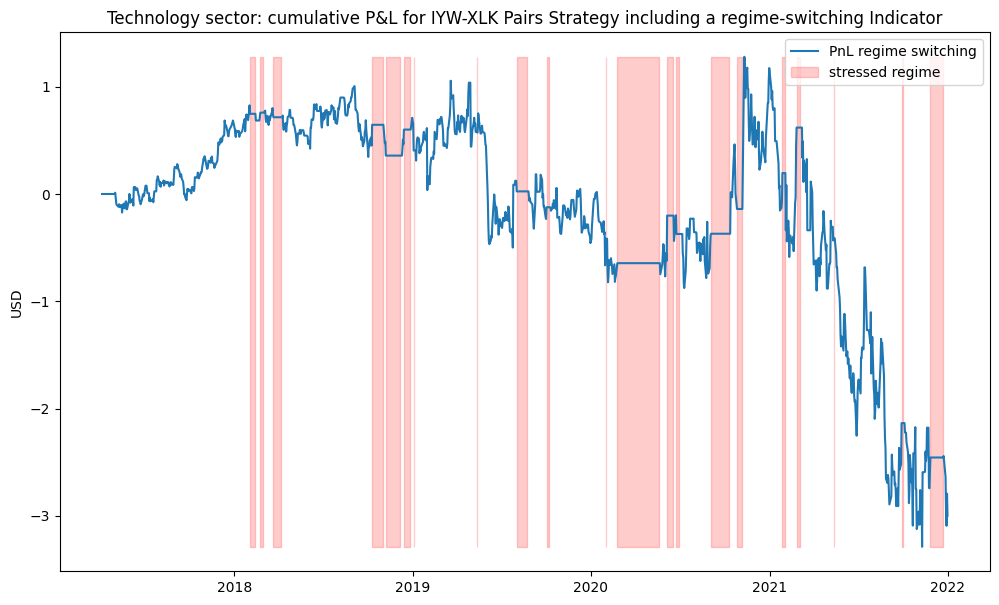

Annualised Sharpe for Technology sector pair strategy ≈ -0.32


In [22]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech_with_switch.shift() * spread_returns
cum_pnl_tech_with_switch = strategy_ret.cumsum()
cum_pnl_tech_with_switch.name = "PnL Technology pair"

min_pnl = cum_pnl_tech_with_switch.min()
max_pnl = cum_pnl_tech_with_switch.max()
# Results
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Technology sector: cumulative P&L for IYW-XLK Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_tech_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech_with_switch:.2f}")

Adding the regime-switching indicator to the pair strategy for the technology sector does in fact make little if any difference in terms of annualised Sharpe ratio, and also as seen in the comparison graph below.

This might be explained with the peculiar nature of the Covid 2020 crisis and the lockdowns, which forced people indoors and as a result spurred growth for electronic devices and internet use.
This sector actually profited from the Covid 2020 crisis, and the the pair strategy fails to take advantage of this.

However, with respect to the vanilla strategy, the improved regime-switching strategy manages to avoid losses during high-volatility periods after 2020, and as a result the two strategies finish at the same level of profitability (loss, really) at the end of the timeframe considered (January 2022).

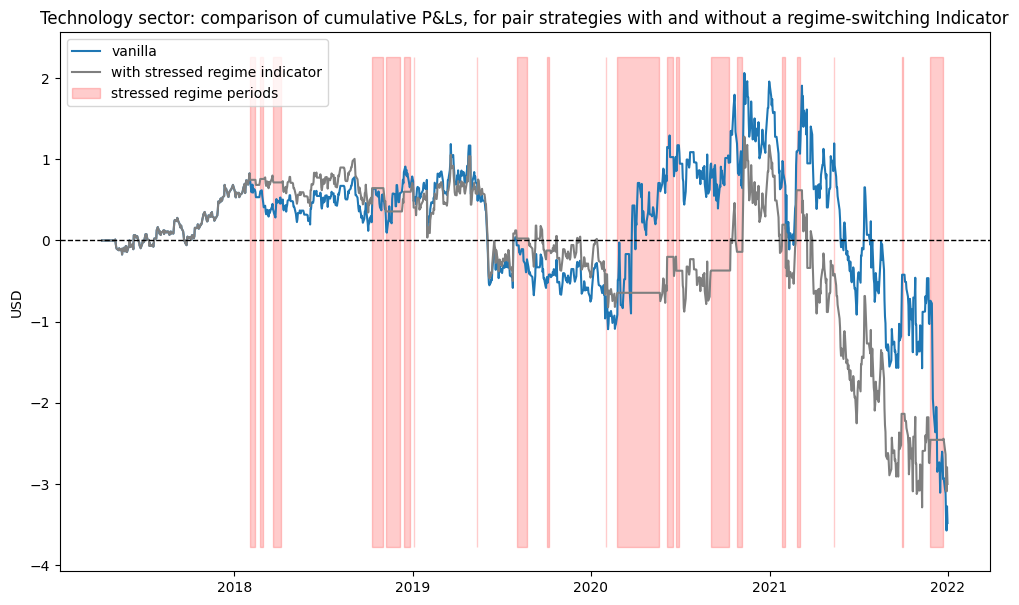

In [23]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_tech_with_switch.min(), cum_pnl_tech_no_switch.min())
max_pnl = max(cum_pnl_tech_with_switch.max(), cum_pnl_tech_no_switch.max())

plt.plot(cum_pnl_tech_no_switch.index, cum_pnl_tech_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Technology sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="upper left")

plt.show()

## Step 3

### Backtest both the vanilla and regime-switching strategy over the period 2017-22. Then include a transaction cost of ten basis points, and calculate performance statistics for both strategies.

In [24]:
pd.set_option('display.precision', 4)

Since we already run backtesting of both strategies for the three pairs of ETFs in section 2, here we will focus on adding a fixed transaction cost $y = 0.001$ to each trade 

$$
r_{\text{spread, net}}(t) = \left[ r_{\text{spread}}(t) - r_{\text{spread}}(t-1) \right] - y \cdot \left| r_{\text{spread}}(t) - r_{\text{spread}}(t-1) \right| = \begin{cases}
    0.999 \cdot \Delta r_{\text{spread}} (t) & \text{if } \Delta r_{\text{spread}} (t) > 0\\
	-1.001 \cdot \left| \Delta r_{\text{spread}} (t) \right| & \text{if } \Delta r_{\text{spread}} (t) < 0\\
	0 & \text{if } \Delta r_{\text{spread}} (t) = 0
\end{cases}
$$

where $r_{\text{spread}} (t)$ is the spread of residuals, which also functions as amount of trade, at any instant $t$ in which either trading strategy is activated, and $$\Delta r_{\text{spread}}(t) = r_{\text{spread}}(t) - r_{\text{spread}}(t-1)$$

#### Performance Statistics

We will also calculate a few indicators in order to track the overall performance of the two pair strategies (vanilla and with added regime-switching) with and without transaction fees.

The performance statistics considered are the following:

1. **Cumulative Returns**: the PnL value of the strategy $S$ at the end of the timeframe considered
2. **Annualised Sharpe Ratio**: assuming a risk-free rate of $0 \%$, this is $$\text{SR} = \frac{\mu_S}{\sigma_S} \sqrt{252}$$
3. **Maximum Drawdown(\%)**: this is the maximum (absolute) distance between a through and the highest preceding peak $$\text{MDD} = \min_{t \in (0, T)} \frac{S(t) - \max_{\overline{t} < t} S(\overline{t})}{\max_{\overline{t} < t} S(\overline{t})} \cdot 100$$
4. **Number of Trades**: the total number of trades entered (in both directions)
5. **Time Activity Ratio(\%)**: the number of trades entered (1 per day) in proportion to the number of business days available in the selected timeframe 2017-22
6. **Winning Rate (\%)**: the ratio of profitable trades over the total of trades entered.

#### 1. Energy ETFs

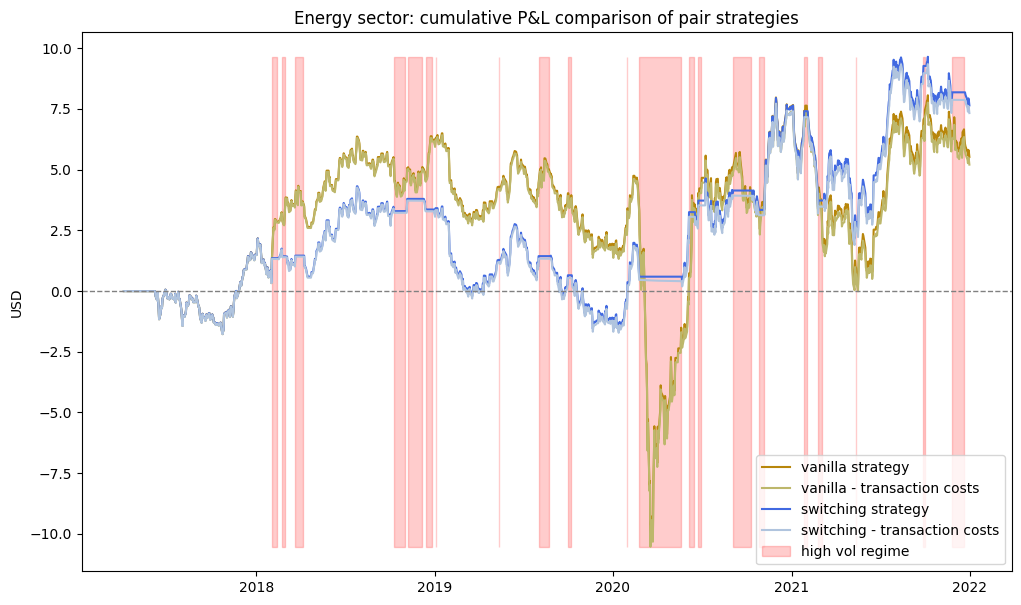

In [25]:
# Strategy returns
shaving = 0.001
spread_returns = spread_energy.iloc[roll_window:].diff()

# original returns
strategy_ret = position_energy_no_switch.shift() * spread_returns
cum_pnl_energy_no_switch = strategy_ret.cumsum().dropna()
cum_pnl_energy_no_switch.name = "PnL Energy pair"
# shaved returns
strategy_ret_shaved = position_energy_no_switch.shift() * spread_returns
strategy_ret_shaved -= shaving * abs(spread_returns)
cum_pnl_energy_no_switch_shaved = strategy_ret_shaved.cumsum().dropna()
cum_pnl_energy_no_switch_shaved.name = "PnL Energy pair"
# original switching returns
strategy_ret_with_switch = position_energy_with_switch.shift() * spread_returns
cum_pnl_energy_with_switch = strategy_ret_with_switch.cumsum().dropna()
cum_pnl_energy_with_switch.name = "PnL Energy pair"
# shaved switching returns
strategy_ret_with_switch_shaved = position_energy_with_switch.shift() * spread_returns
strategy_ret_with_switch_shaved -= shaving * abs(spread_returns)
cum_pnl_energy_with_switch_shaved = strategy_ret_with_switch_shaved.cumsum().dropna()
cum_pnl_energy_with_switch_shaved.name = "PnL Energy pair"

# Results
fig = plt.subplots()
plt.plot(cum_pnl_energy_no_switch.index, cum_pnl_energy_no_switch, color='darkgoldenrod', label="vanilla strategy")
plt.plot(cum_pnl_energy_no_switch_shaved.index, cum_pnl_energy_no_switch_shaved, color='darkkhaki', label="vanilla - transaction costs")
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, color='royalblue', label="switching strategy")
plt.plot(cum_pnl_energy_with_switch_shaved.index, cum_pnl_energy_with_switch_shaved, color='lightsteelblue', label="switching - transaction costs")
plt.axhline(0, ls="--", color="gray", lw=1)
min_pnl = cum_pnl_energy_no_switch_shaved.min()
max_pnl = cum_pnl_energy_with_switch.max()
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="high vol regime")
plt.ylabel("USD")
plt.title("Energy sector: cumulative P&L comparison of pair strategies")
plt.legend(loc="lower right")
plt.show()

In [26]:
annual_sharpe_energy_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
annual_sharpe_energy_no_switch_shaved = (strategy_ret_shaved.mean() / strategy_ret_shaved.std()) * np.sqrt(252)
annual_sharpe_energy_with_switch = (strategy_ret_with_switch.mean() / strategy_ret_with_switch.std()) * np.sqrt(252)
annual_sharpe_energy_with_switch_shaved = (strategy_ret_with_switch_shaved.mean() / strategy_ret_with_switch_shaved.std()) * np.sqrt(252)
# print(f"Annualised Sharpe for Energy sector pair vanilla strategy ≈ {annual_sharpe_energy_no_switch:.2f}")
# print(f"Annualised Sharpe for Energy sector pair vanilla strategy with transaction costs ≈ {annual_sharpe_energy_no_switch_shaved:.2f}")
# print(f"Annualised Sharpe for Energy sector pair regime switching strategy ≈ {annual_sharpe_energy_with_switch:.2f}")
# print(f"Annualised Sharpe for Energy sector pair regime switching strategy with transaction costs ≈ {annual_sharpe_energy_with_switch_shaved:.2f}")

As it could be expected, transaction costs shave a little profit away from both pair strategies.

In [27]:
# drawdown function
def computeDrawdown(series):
	local_min = series[0]
	local_max = series[0]
	min_drawdown = 0
	for trade in series:
		local_min = min(local_min, trade)
		local_max = max(local_max, trade)
		if local_max == trade:
			local_min = trade
		# taking the division only at the end avoids
		# amplifying drawdowns at near zero profits/losses
		drawdown = (local_min - local_max) #/ local_max
		if local_max == 0:
			drawdown = 0
		min_drawdown = min(min_drawdown, drawdown)
		if min_drawdown == drawdown:
			max_at_drawdown = local_max
		#print(min_drawdown, local_min, local_max, trade)
	
	return min_drawdown/max_at_drawdown

In [28]:
def numberOfTrades(pandas_series):
    return np.count_nonzero(pandas_series)

In [29]:
def winRate(series, regime_switch_bool):
    total_trades= 0
    if regime_switch_bool:
        total_trades = numberOfTrades(position_energy_with_switch)
    else:
        total_trades = numberOfTrades(position_energy_no_switch)
        
    days_winning = len( np.extract(series > series.shift(), series) )

    return days_winning / total_trades

Below, a summary table of the six performance indicators considered, for both pair strategies (vanilla and with regime-switching indicator), with and without transaction costs, hence a total of four cases.

Following that, a graphic representation of the performance indicators 

- first, for just the two pair strategies as impacted by transaction costs
- then, for all four strategy variants, but only covering three performance indicators, as the other three show no difference between strategies with or without transaction costs.

In [30]:
strategies_shaved = ["vanilla", "switching"]
strategies = ["vanilla", "vanilla - t. costs", "switching", "switching - t. costs"]

# compare cumulative returns
final_pnl_shaved = np.array([cum_pnl_energy_no_switch_shaved[-1], cum_pnl_energy_with_switch_shaved[-1]])
final_pnl = np.array([cum_pnl_energy_no_switch[-1], cum_pnl_energy_no_switch_shaved[-1], cum_pnl_energy_with_switch[-1], cum_pnl_energy_with_switch_shaved[-1]])

# compare annualised Sharpe ratios
sharpe_shaved = np.array([annual_sharpe_energy_no_switch_shaved, annual_sharpe_energy_with_switch_shaved])
sharpe = np.array([annual_sharpe_energy_no_switch, annual_sharpe_energy_no_switch_shaved, annual_sharpe_energy_with_switch, annual_sharpe_energy_with_switch_shaved])

# maximum drawdown
drawdown_shaved= np.array([
    computeDrawdown(cum_pnl_energy_no_switch_shaved),
    computeDrawdown(cum_pnl_energy_with_switch_shaved)
])
drawdown = np.array([
    computeDrawdown(cum_pnl_energy_no_switch),
    computeDrawdown(cum_pnl_energy_no_switch_shaved),
    computeDrawdown(cum_pnl_energy_with_switch),
    computeDrawdown(cum_pnl_energy_with_switch_shaved)
])

# number of trades
trades_shaved = np.array([
    numberOfTrades(position_energy_no_switch),
    numberOfTrades(position_energy_with_switch)
])
trades = np.array([
    numberOfTrades(position_energy_no_switch),
    numberOfTrades(position_energy_no_switch),
    numberOfTrades(position_energy_with_switch),
    numberOfTrades(position_energy_with_switch)
])

# % time active
time_active_shaved = trades_shaved / position_energy_no_switch.shape[0]
time_active = trades / position_energy_no_switch.shape[0]

# % winning trades
winning_rate_shaved = np.array([
    winRate(cum_pnl_energy_no_switch, False),
    winRate(cum_pnl_energy_with_switch, True)
])
winning_rate = np.array([
    winRate(cum_pnl_energy_no_switch, False),
    winRate(cum_pnl_energy_no_switch_shaved, False),
    winRate(cum_pnl_energy_with_switch, True),
    winRate(cum_pnl_energy_with_switch_shaved, True)
])

perf_stats_names = ["Cumulative Return", "Annualised Sharpe Ratio", "% Maximum Drawdown", "Number of Trades", "% Time Active", "% Winning Rate"]

performance_energy = pd.DataFrame(data=np.stack((final_pnl, sharpe, drawdown * 100, trades, time_active * 100, winning_rate * 100), axis=1), index=strategies, columns=perf_stats_names)
performance_energy.index.name = "Energy Strategies"
performance_energy

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Energy Strategies,,,,,,
vanilla,5.5225,0.1914,-259.7551,1054.0,88.1271,50.0949
vanilla - t. costs,5.2059,0.1805,-264.1556,1054.0,88.1271,50.0949
switching,7.6442,0.3873,-136.9167,837.0,69.9833,50.5376
switching - t. costs,7.3276,0.3713,-140.3672,837.0,69.9833,50.5376


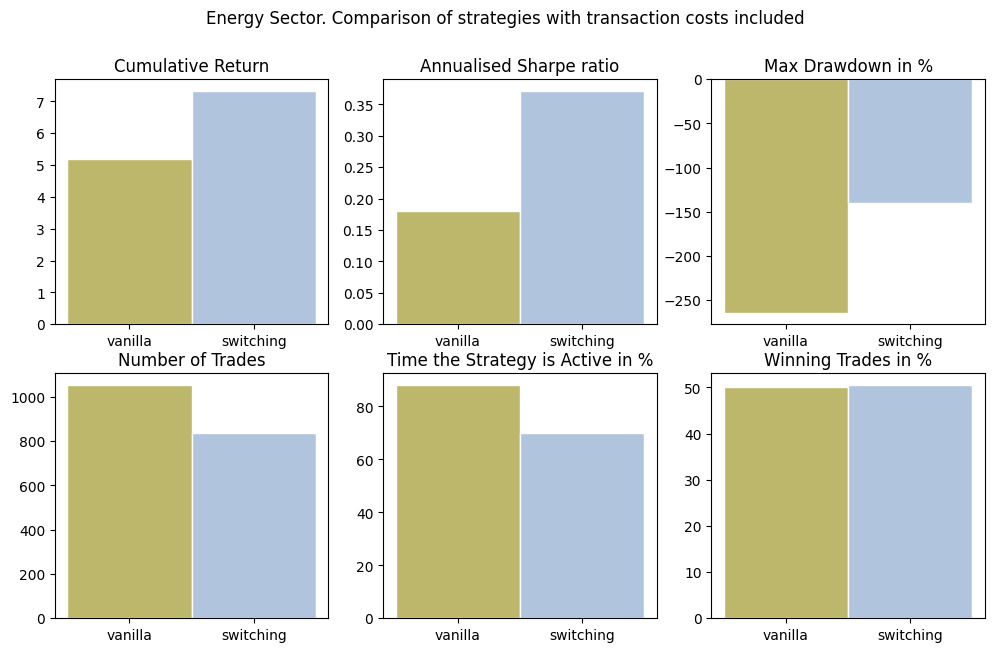

In [31]:
fig, ax = plt.subplots(2, 3)

ax[0,0].bar(strategies_shaved, final_pnl_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,0].set_title("Cumulative Return")
ax[0,1].bar(strategies_shaved, sharpe_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[0,1].set_title("Annualised Sharpe ratio")
ax[0,2].bar(strategies_shaved, drawdown_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,2].set_title("Max Drawdown in %")
ax[1,0].bar(strategies_shaved, trades_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,0].set_title("Number of Trades")
ax[1,1].bar(strategies_shaved, time_active_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,1].set_title("Time the Strategy is Active in %")
ax[1,2].bar(strategies_shaved, winning_rate_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Energy Sector. Comparison of strategies with transaction costs included")

plt.tight_layout
plt.show()

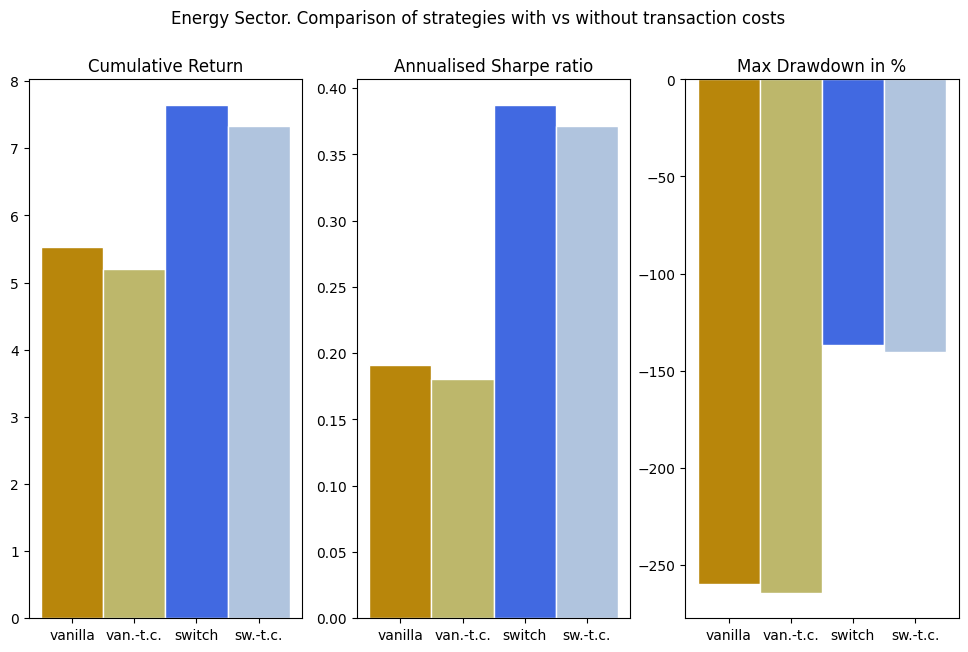

In [32]:
strategies_brief = ["vanilla", "van.-t.c.", "switch", "sw.-t.c."]
fig, ax = plt.subplots(1, 3)

ax[0].bar(strategies_brief, final_pnl, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0].set_title("Cumulative Return")
ax[1].bar(strategies_brief, sharpe, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[1].set_title("Annualised Sharpe ratio")
ax[2].bar(strategies_brief, drawdown * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[2].set_title("Max Drawdown in %")
# ax[1,0].bar(strategies, trades, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,0].set_title("Number of Trades")
# ax[1,1].bar(strategies, time_active * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,1].set_title("Time the Strategy is Active in %")
# ax[1,2].bar(strategies, winning_rate * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Energy Sector. Comparison of strategies with vs without transaction costs")

plt.tight_layout
plt.show()

#### 2. Gold ETFs

The backtest and the performance analysis here is the same as done for the Energy pair strategy.

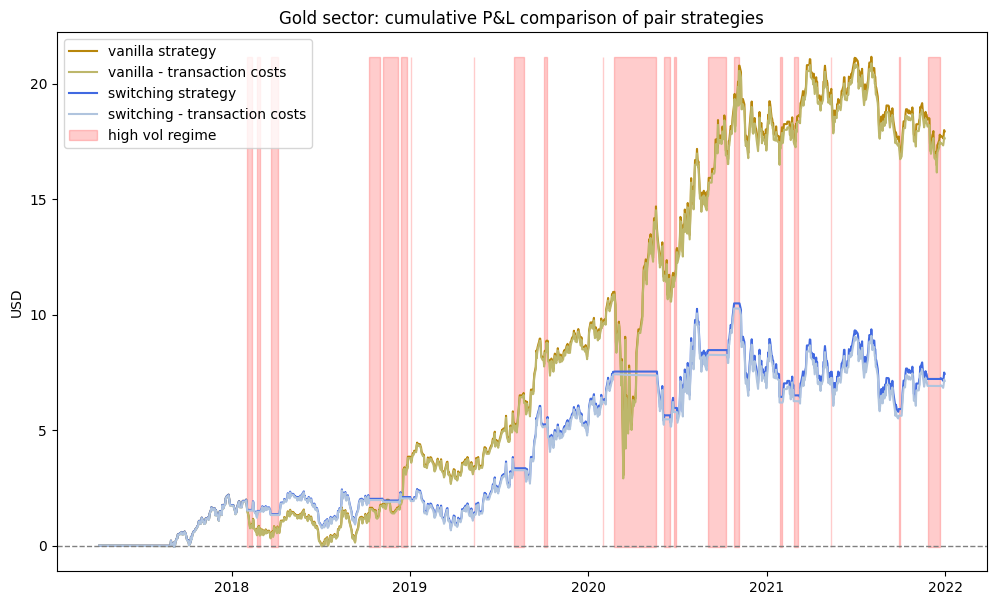

In [33]:
# Strategy returns
shaving = 0.001
spread_returns = spread_gold.iloc[roll_window:].diff()

# original returns
strategy_ret = position_gold_no_switch.shift() * spread_returns
cum_pnl_gold_no_switch = strategy_ret.cumsum().dropna()
cum_pnl_gold_no_switch.name = "PnL Gold pair"
# shaved returns
strategy_ret_shaved = position_gold_no_switch.shift() * spread_returns
strategy_ret_shaved -= shaving * abs(spread_returns)
cum_pnl_gold_no_switch_shaved = strategy_ret_shaved.cumsum().dropna()
cum_pnl_gold_no_switch_shaved.name = "PnL Gold pair"
# original switching returns
strategy_ret_with_switch = position_gold_with_switch.shift() * spread_returns
cum_pnl_gold_with_switch = strategy_ret_with_switch.cumsum().dropna()
cum_pnl_gold_with_switch.name = "PnL Gold pair"
# shaved switching returns
strategy_ret_with_switch_shaved = position_gold_with_switch.shift() * spread_returns
strategy_ret_with_switch_shaved -= shaving * abs(spread_returns)
cum_pnl_gold_with_switch_shaved = strategy_ret_with_switch_shaved.cumsum().dropna()
cum_pnl_gold_with_switch_shaved.name = "PnL Gold pair"

# Results
fig = plt.subplots()
plt.plot(cum_pnl_gold_no_switch.index, cum_pnl_gold_no_switch, color='darkgoldenrod', label="vanilla strategy")
plt.plot(cum_pnl_gold_no_switch_shaved.index, cum_pnl_gold_no_switch_shaved, color='darkkhaki', label="vanilla - transaction costs")
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, color='royalblue', label="switching strategy")
plt.plot(cum_pnl_gold_with_switch_shaved.index, cum_pnl_gold_with_switch_shaved, color='lightsteelblue', label="switching - transaction costs")
plt.axhline(0, ls="--", color="gray", lw=1)
min_pnl = cum_pnl_gold_no_switch_shaved.min()
max_pnl = cum_pnl_gold_no_switch.max()
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="high vol regime")
plt.ylabel("USD")
plt.title("Gold sector: cumulative P&L comparison of pair strategies")
plt.legend(loc="upper left")
plt.show()

In [34]:
annual_sharpe_gold_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
annual_sharpe_gold_no_switch_shaved = (strategy_ret_shaved.mean() / strategy_ret_shaved.std()) * np.sqrt(252)
annual_sharpe_gold_with_switch = (strategy_ret_with_switch.mean() / strategy_ret_with_switch.std()) * np.sqrt(252)
annual_sharpe_gold_with_switch_shaved = (strategy_ret_with_switch_shaved.mean() / strategy_ret_with_switch_shaved.std()) * np.sqrt(252)

In [35]:
strategies_shaved = ["vanilla", "switching"]
strategies = ["vanilla", "vanilla - t. costs", "switching", "switching - t. costs"]

# compare cumulative returns
final_pnl_shaved = np.array([cum_pnl_gold_no_switch_shaved[-1], cum_pnl_gold_with_switch_shaved[-1]])
final_pnl = np.array([cum_pnl_gold_no_switch[-1], cum_pnl_gold_no_switch_shaved[-1], cum_pnl_gold_with_switch[-1], cum_pnl_gold_with_switch_shaved[-1]])

# compare annualised Sharpe ratios
sharpe_shaved = np.array([annual_sharpe_gold_no_switch_shaved, annual_sharpe_gold_with_switch_shaved])
sharpe = np.array([annual_sharpe_gold_no_switch, annual_sharpe_gold_no_switch_shaved, annual_sharpe_gold_with_switch, annual_sharpe_gold_with_switch_shaved])

# maximum drawdown
drawdown_shaved= np.array([
    computeDrawdown(cum_pnl_gold_no_switch_shaved),
    computeDrawdown(cum_pnl_gold_with_switch_shaved)
])
drawdown = np.array([
    computeDrawdown(cum_pnl_gold_no_switch),
    computeDrawdown(cum_pnl_gold_no_switch_shaved),
    computeDrawdown(cum_pnl_gold_with_switch),
    computeDrawdown(cum_pnl_gold_with_switch_shaved)
])

# number of trades
trades_shaved = np.array([
    numberOfTrades(position_gold_no_switch),
    numberOfTrades(position_gold_with_switch)
])
trades = np.array([
    numberOfTrades(position_gold_no_switch),
    numberOfTrades(position_gold_no_switch),
    numberOfTrades(position_gold_with_switch),
    numberOfTrades(position_gold_with_switch)
])

# % time active
time_active_shaved = trades_shaved / position_gold_no_switch.shape[0]
time_active = trades / position_gold_no_switch.shape[0]

# % winning trades
winning_rate_shaved = np.array([
    winRate(cum_pnl_gold_no_switch, False),
    winRate(cum_pnl_gold_with_switch, True)
])
winning_rate = np.array([
    winRate(cum_pnl_gold_no_switch, False),
    winRate(cum_pnl_gold_no_switch_shaved, False),
    winRate(cum_pnl_gold_with_switch, True),
    winRate(cum_pnl_gold_with_switch_shaved, True)
])

perf_stats_names = ["Cumulative Return", "Annualised Sharpe Ratio", "% Maximum Drawdown", "Number of Trades", "% Time Active", "% Winning Rate"]

performance_gold = pd.DataFrame(data=np.stack((final_pnl, sharpe, drawdown * 100, trades, time_active * 100, winning_rate * 100), axis=1), index=strategies, columns=perf_stats_names)
performance_gold.index.name = "Gold Strategies"
performance_gold

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Gold Strategies,,,,,,
vanilla,17.9386,0.6078,-72.3195,985.0,82.3579,47.7230
vanilla - t. costs,17.6332,0.5975,-73.2130,985.0,82.3579,47.7230
switching,7.4407,0.3993,-44.7320,779.0,65.1338,46.8339
switching - t. costs,7.1352,0.3829,-46.3761,779.0,65.1338,46.8339


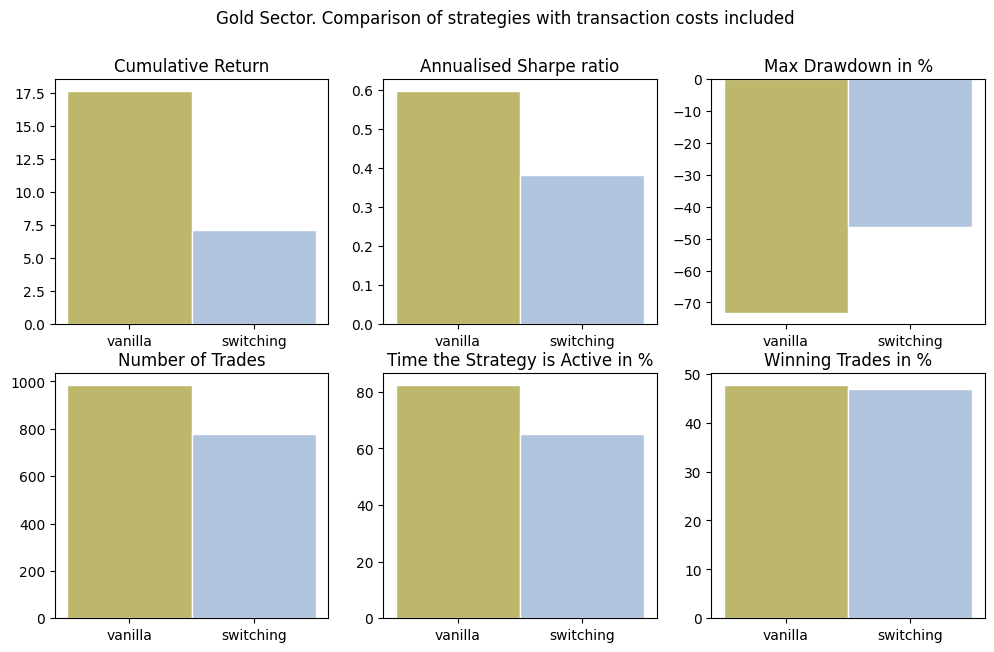

In [36]:
fig, ax = plt.subplots(2, 3)

ax[0,0].bar(strategies_shaved, final_pnl_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,0].set_title("Cumulative Return")
ax[0,1].bar(strategies_shaved, sharpe_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,1].set_title("Annualised Sharpe ratio")
ax[0,2].bar(strategies_shaved, drawdown_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,2].set_title("Max Drawdown in %")
ax[1,0].bar(strategies_shaved, trades_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,0].set_title("Number of Trades")
ax[1,1].bar(strategies_shaved, time_active_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,1].set_title("Time the Strategy is Active in %")
ax[1,2].bar(strategies_shaved, winning_rate_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Gold Sector. Comparison of strategies with transaction costs included")

plt.tight_layout
plt.show()

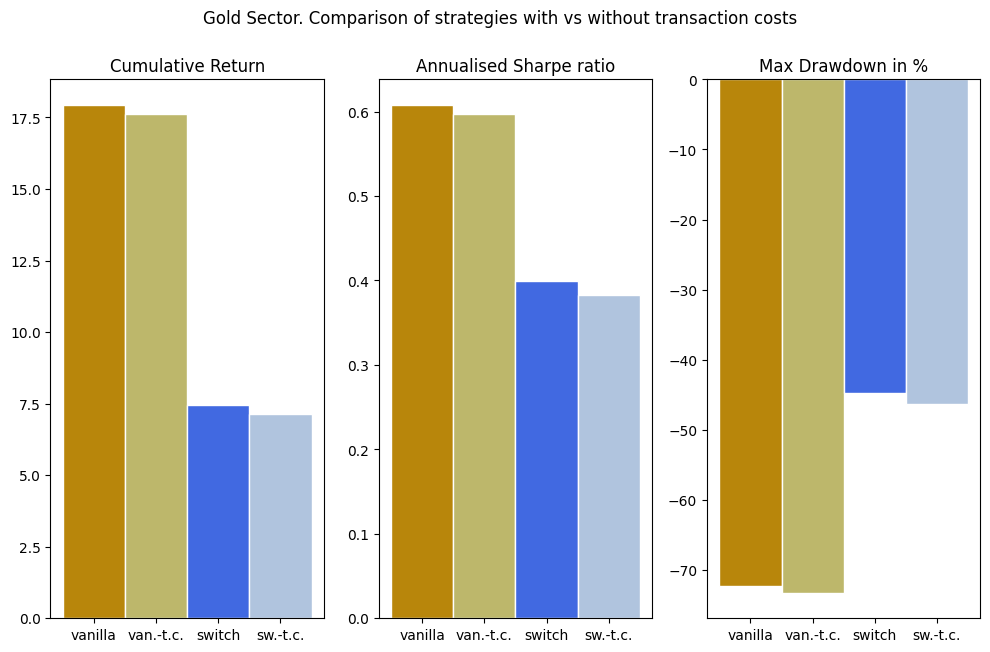

In [37]:
strategies_brief = ["vanilla", "van.-t.c.", "switch", "sw.-t.c."]
fig, ax = plt.subplots(1, 3)

ax[0].bar(strategies_brief, final_pnl, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0].set_title("Cumulative Return")
ax[1].bar(strategies_brief, sharpe, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1) 
ax[1].set_title("Annualised Sharpe ratio")
ax[2].bar(strategies_brief, drawdown * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[2].set_title("Max Drawdown in %")

fig.suptitle("Gold Sector. Comparison of strategies with vs without transaction costs")

plt.tight_layout
plt.show()

#### 3. Technology ETFs

The backtest and the performance analysis here is the same as done for the Energy pair strategy.

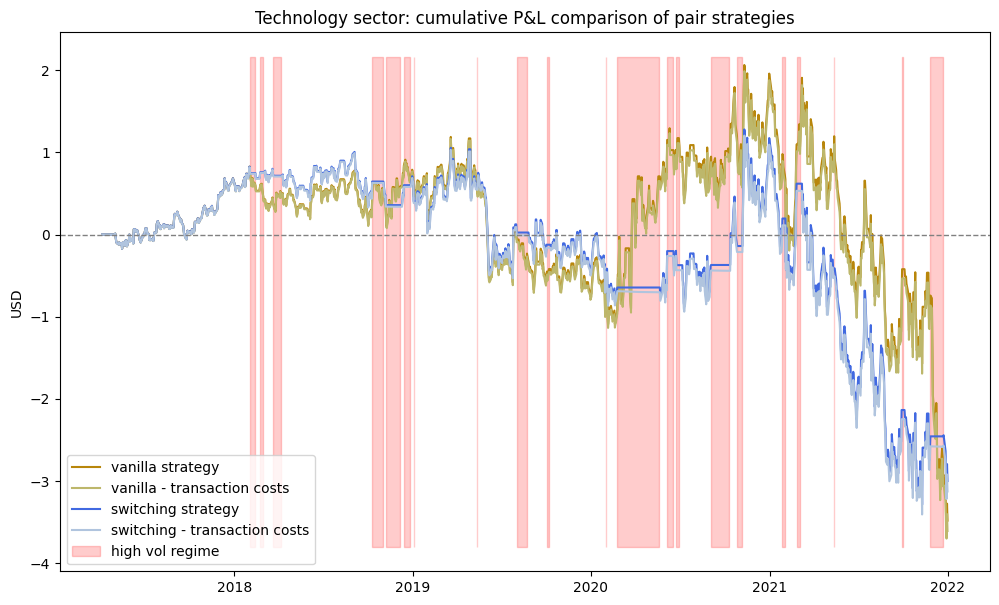

In [38]:
# Strategy returns
shaving = 0.001
spread_returns = spread_tech.iloc[roll_window:].diff()

# original returns
strategy_ret = position_tech_no_switch.shift() * spread_returns
cum_pnl_tech_no_switch = strategy_ret.cumsum().dropna()
cum_pnl_tech_no_switch.name = "PnL Technology pair"
# shaved returns
strategy_ret_shaved = position_tech_no_switch.shift() * spread_returns
strategy_ret_shaved -= shaving * abs(spread_returns)
cum_pnl_tech_no_switch_shaved = strategy_ret_shaved.cumsum().dropna()
cum_pnl_tech_no_switch_shaved.name = "PnL Technology pair"
# original switching returns
strategy_ret_with_switch = position_tech_with_switch.shift() * spread_returns
cum_pnl_tech_with_switch = strategy_ret_with_switch.cumsum().dropna()
cum_pnl_tech_with_switch.name = "PnL Technology pair"
# shaved switching returns
strategy_ret_with_switch_shaved = position_tech_with_switch.shift() * spread_returns
strategy_ret_with_switch_shaved -= shaving * abs(spread_returns)
cum_pnl_tech_with_switch_shaved = strategy_ret_with_switch_shaved.cumsum().dropna()
cum_pnl_tech_with_switch_shaved.name = "PnL Technology pair"

# Results
fig = plt.subplots()
plt.plot(cum_pnl_tech_no_switch.index, cum_pnl_tech_no_switch, color='darkgoldenrod', label="vanilla strategy")
plt.plot(cum_pnl_tech_no_switch_shaved.index, cum_pnl_tech_no_switch_shaved, color='darkkhaki', label="vanilla - transaction costs")
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, color='royalblue', label="switching strategy")
plt.plot(cum_pnl_tech_with_switch_shaved.index, cum_pnl_tech_with_switch_shaved, color='lightsteelblue', label="switching - transaction costs")
plt.axhline(0, ls="--", color="gray", lw=1)
min_pnl = cum_pnl_tech_no_switch_shaved.min() - 0.1
max_pnl = cum_pnl_tech_no_switch.max() + 0.1
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="high vol regime")
plt.ylabel("USD")
plt.title("Technology sector: cumulative P&L comparison of pair strategies")
plt.legend(loc="lower left")
plt.show()

In [39]:
annual_sharpe_tech_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
annual_sharpe_tech_no_switch_shaved = (strategy_ret_shaved.mean() / strategy_ret_shaved.std()) * np.sqrt(252)
annual_sharpe_tech_with_switch = (strategy_ret_with_switch.mean() / strategy_ret_with_switch.std()) * np.sqrt(252)
annual_sharpe_tech_with_switch_shaved = (strategy_ret_with_switch_shaved.mean() / strategy_ret_with_switch_shaved.std()) * np.sqrt(252)

In [40]:
strategies_shaved = ["vanilla", "switching"]
strategies = ["vanilla", "vanilla - t. costs", "switching", "switching - t. costs"]

# compare cumulative returns
final_pnl_shaved = np.array([cum_pnl_tech_no_switch_shaved[-1], cum_pnl_tech_with_switch_shaved[-1]])
final_pnl = np.array([cum_pnl_tech_no_switch[-1], cum_pnl_tech_no_switch_shaved[-1], cum_pnl_tech_with_switch[-1], cum_pnl_tech_with_switch_shaved[-1]])

# compare annualised Sharpe ratios
sharpe_shaved = np.array([annual_sharpe_tech_no_switch_shaved, annual_sharpe_tech_with_switch_shaved])
sharpe = np.array([annual_sharpe_tech_no_switch, annual_sharpe_tech_no_switch_shaved, annual_sharpe_tech_with_switch, annual_sharpe_tech_with_switch_shaved])

# maximum drawdown
drawdown_shaved= np.array([
    computeDrawdown(cum_pnl_tech_no_switch_shaved),
    computeDrawdown(cum_pnl_tech_with_switch_shaved)
])
drawdown = np.array([
    computeDrawdown(cum_pnl_tech_no_switch),
    computeDrawdown(cum_pnl_tech_no_switch_shaved),
    computeDrawdown(cum_pnl_tech_with_switch),
    computeDrawdown(cum_pnl_tech_with_switch_shaved)
])

# number of trades
trades_shaved = np.array([
    numberOfTrades(position_tech_no_switch),
    numberOfTrades(position_tech_with_switch)
])
trades = np.array([
    numberOfTrades(position_tech_no_switch),
    numberOfTrades(position_tech_no_switch),
    numberOfTrades(position_tech_with_switch),
    numberOfTrades(position_tech_with_switch)
])

# % time active
time_active_shaved = trades_shaved / position_tech_no_switch.shape[0]
time_active = trades / position_tech_no_switch.shape[0]

# % winning trades
winning_rate_shaved = np.array([
    winRate(cum_pnl_tech_no_switch, False),
    winRate(cum_pnl_tech_with_switch, True)
])
winning_rate = np.array([
    winRate(cum_pnl_tech_no_switch, False),
    winRate(cum_pnl_tech_no_switch_shaved, False),
    winRate(cum_pnl_tech_with_switch, True),
    winRate(cum_pnl_tech_with_switch_shaved, True)
])

perf_stats_names = ["Cumulative Return", "Annualised Sharpe Ratio", "% Maximum Drawdown", "Number of Trades", "% Time Active", "% Winning Rate"]

performance_tech = pd.DataFrame(data=np.stack((final_pnl, sharpe, drawdown * 100, trades, time_active * 100, winning_rate * 100), axis=1), index=strategies, columns=perf_stats_names)
performance_tech.index.name = "Tech Strategies"
performance_tech

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Tech Strategies,,,,,,
vanilla,-3.4811,-0.3094,-273.2057,1034.0,86.4548,47.9127
vanilla - t. costs,-3.6077,-0.3207,-286.0860,1034.0,86.4548,47.9127
switching,-2.9996,-0.3172,-357.1087,845.0,70.6522,49.5818
switching - t. costs,-3.1262,-0.3306,-382.9703,845.0,70.6522,49.5818


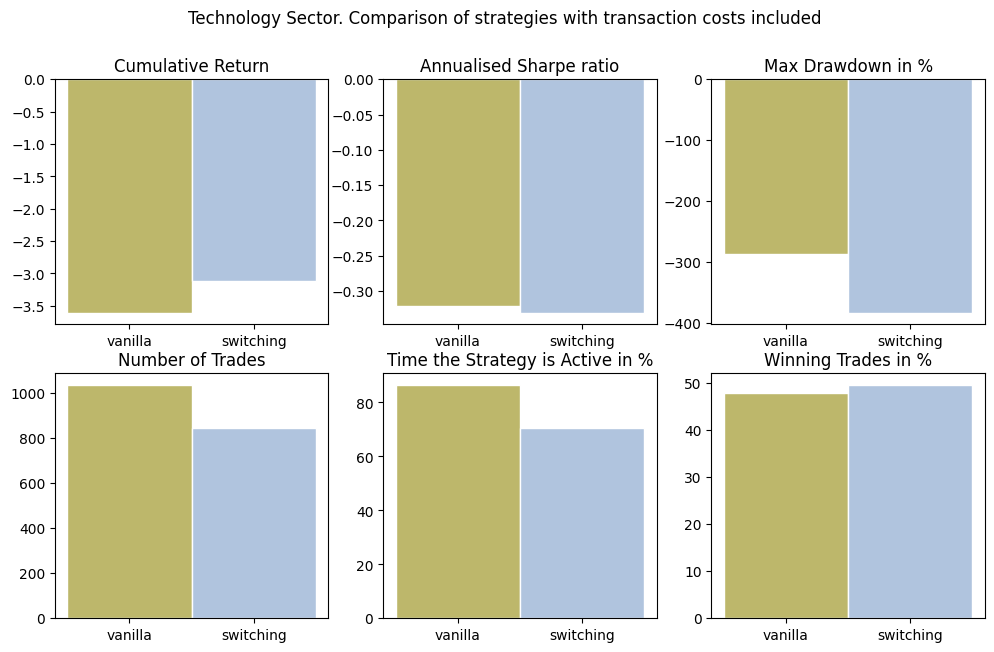

In [41]:
fig, ax = plt.subplots(2, 3)

ax[0,0].bar(strategies_shaved, final_pnl_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,0].set_title("Cumulative Return")
ax[0,1].bar(strategies_shaved, sharpe_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[0,1].set_title("Annualised Sharpe ratio")
ax[0,2].bar(strategies_shaved, drawdown_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,2].set_title("Max Drawdown in %")
ax[1,0].bar(strategies_shaved, trades_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,0].set_title("Number of Trades")
ax[1,1].bar(strategies_shaved, time_active_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,1].set_title("Time the Strategy is Active in %")
ax[1,2].bar(strategies_shaved, winning_rate_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Technology Sector. Comparison of strategies with transaction costs included")

plt.tight_layout
plt.show()

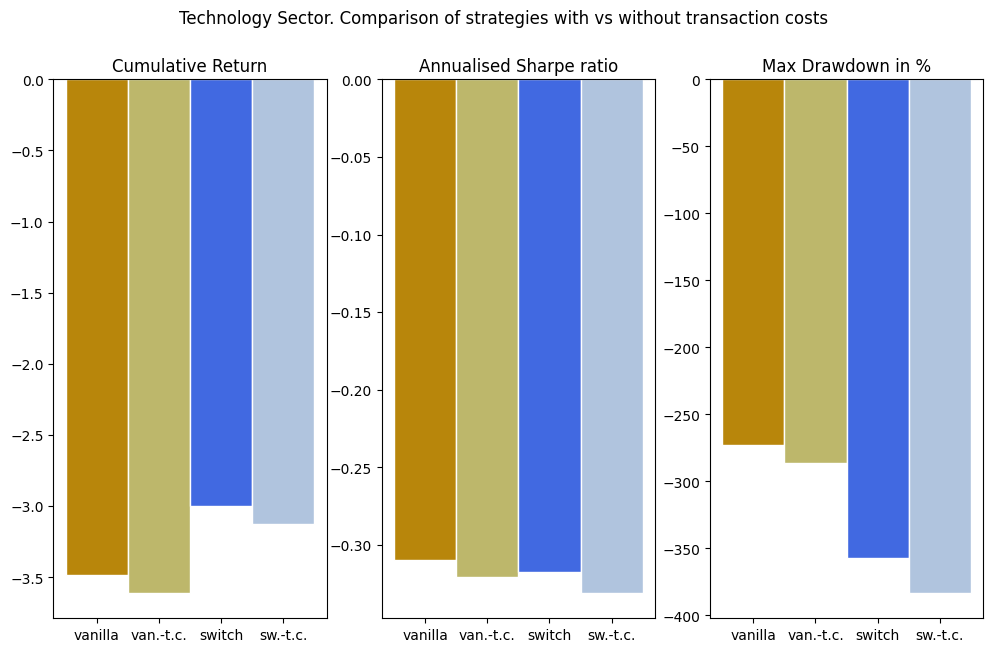

In [42]:
strategies_brief = ["vanilla", "van.-t.c.", "switch", "sw.-t.c."]
fig, ax = plt.subplots(1, 3)

ax[0].bar(strategies_brief, final_pnl, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0].set_title("Cumulative Return")
ax[1].bar(strategies_brief, sharpe, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[1].set_title("Annualised Sharpe ratio")
ax[2].bar(strategies_brief, drawdown * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[2].set_title("Max Drawdown in %")
# ax[1,0].bar(strategies, trades, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,0].set_title("Number of Trades")
# ax[1,1].bar(strategies, time_active * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,1].set_title("Time the Strategy is Active in %")
# ax[1,2].bar(strategies, winning_rate * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Technology Sector. Comparison of strategies with vs without transaction costs")

plt.tight_layout
plt.show()

## Step 4

### Interpretation of Results and Critical Analysis

We begin the section by briefly summarising performance results from Step 3 for the pair strategies of all three sectors.

Then, we also add a cross comparison across the three sectors (energy, gold, technology) for pair strategies with regime-switching indicator and with transaction fees included.

In [43]:
performance_energy

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Energy Strategies,,,,,,
vanilla,5.5225,0.1914,-259.7551,1054.0,88.1271,50.0949
vanilla - t. costs,5.2059,0.1805,-264.1556,1054.0,88.1271,50.0949
switching,7.6442,0.3873,-136.9167,837.0,69.9833,50.5376
switching - t. costs,7.3276,0.3713,-140.3672,837.0,69.9833,50.5376


In [44]:
performance_gold

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Gold Strategies,,,,,,
vanilla,17.9386,0.6078,-72.3195,985.0,82.3579,47.7230
vanilla - t. costs,17.6332,0.5975,-73.2130,985.0,82.3579,47.7230
switching,7.4407,0.3993,-44.7320,779.0,65.1338,46.8339
switching - t. costs,7.1352,0.3829,-46.3761,779.0,65.1338,46.8339


In [45]:
performance_tech

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Tech Strategies,,,,,,
vanilla,-3.4811,-0.3094,-273.2057,1034.0,86.4548,47.9127
vanilla - t. costs,-3.6077,-0.3207,-286.0860,1034.0,86.4548,47.9127
switching,-2.9996,-0.3172,-357.1087,845.0,70.6522,49.5818
switching - t. costs,-3.1262,-0.3306,-382.9703,845.0,70.6522,49.5818


In [46]:
# cross-sector comparison of switching strategies with transaction costs included
cp_index = ["Energy", "Gold", "Technology"]
cross_performance = pd.DataFrame(data=np.stack((performance_energy.loc["switching - t. costs"], performance_gold.loc["switching - t. costs"], performance_tech.loc["switching - t. costs"]), axis=0), index=cp_index, columns=perf_stats_names)
cross_performance.index.name = "switch + fees"
cross_performance

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
switch + fees,,,,,,
Energy,7.3276,0.3713,-140.3672,837.0,69.9833,50.5376
Gold,7.1352,0.3829,-46.3761,779.0,65.1338,46.8339
Technology,-3.1262,-0.3306,-382.9703,845.0,70.6522,49.5818


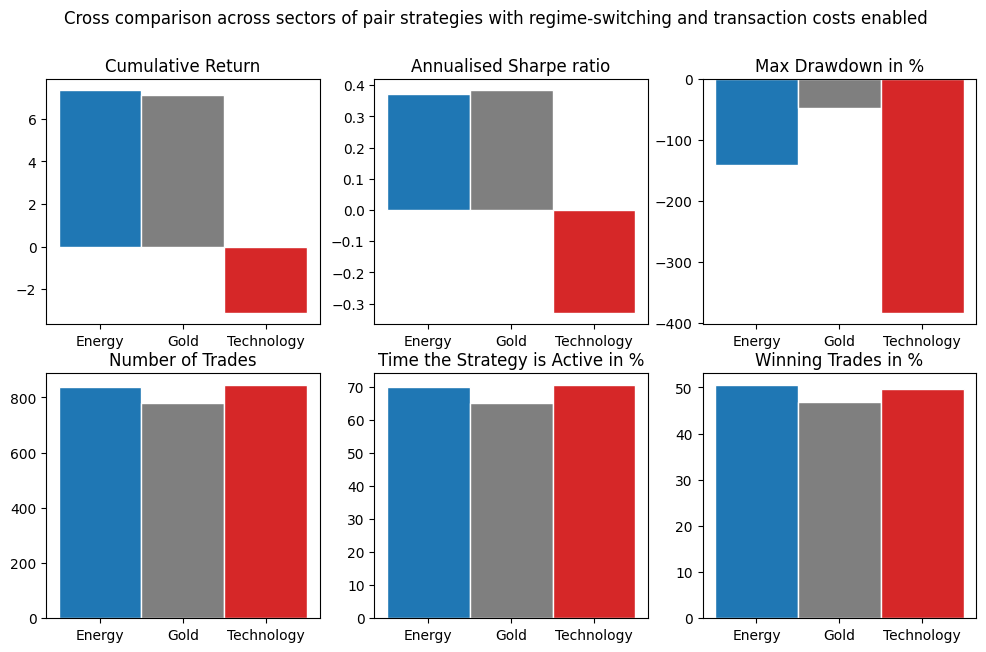

In [47]:
fig, ax = plt.subplots(2, 3)

ax[0,0].bar(cross_performance.index, cross_performance["Cumulative Return"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[0,0].set_title("Cumulative Return")
ax[0,1].bar(cross_performance.index, cross_performance["Annualised Sharpe Ratio"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[0,1].set_title("Annualised Sharpe ratio")
ax[0,2].bar(cross_performance.index, cross_performance["% Maximum Drawdown"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[0,2].set_title("Max Drawdown in %")
ax[1,0].bar(cross_performance.index, cross_performance["Number of Trades"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[1,0].set_title("Number of Trades")
ax[1,1].bar(cross_performance.index, cross_performance["% Time Active"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[1,1].set_title("Time the Strategy is Active in %")
ax[1,2].bar(cross_performance.index, cross_performance["% Winning Rate"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Cross comparison across sectors of pair strategies with regime-switching and transaction costs enabled")

plt.tight_layout
plt.show()

##### Did the regime-filtering hypothesis hold, with the filtered strategy achieving better performance even with lower returns?

- **Energy sector**: this is the pair strategy which benefitted the most from adding the regime-switching indicator based on high-volatility of the SPY.
Final returns increase from $5.21$ vanilla to $7.33$ after adding the regime-switching indicator. 
Annualised Sharpe Ratio more than doubles going from $0.18$ vanilla to $0.37$ with regime-switch on.
Maximum Drawdown also drops by nearly a half, going from $-264 \%$ vanilla to $-140.4 \%$ with regime-switch on.
Notice here we are comparing numbers from the transaction fees-enabled versions of the pair strategy.
The remaining performance measures reveal a beneficial decrease by about $20 \%$ of number of trades involved and of active days for the strategy in the business calendar, when regime-switching indicator is turned on.
The percentage of winning trades is a shaving better for the regime-switching enable version of the strategy, however nothing of substance, with both the enhanced version and the vanilla strategy hovering around the $50 \%$-success-trades mark.

- **Gold sector**: we recall from results in Section 1.b, that this was the best co-integrated pair of ETFs amongst the three considered.
As a consequence, this pair strategy did not receive any benefit from adding a regime-switching volatility indicator.
In fact, the vanilla version outperforms the regime-switch enabled one in terms of cumulative return (a whopping $17.63$ against $7.14$), of annualised Sharpe ratio ($0.6$ against $0.38$) while being expectedly worse in terms of maximum drawdown ($-73.2 \%$ against $-46.38 \%$), as the regime-switching strategy will obviously assume a more conservative outlook.
This last effect is also reflected in a lower number of trades ($985$ against $779$) and time activity ($82.36 \%$ against $65.13 \%$) for the regime-switching version of the pair strategy. Winning trades are a tad better for the vanilla strategy ($47.72 \%$ against $46.83 \%$).
Adding the transaction fees slightly worsens returns, Sharpe ratio and maximum drawdown, as expected.

- **Technology sector**: this is the pair strategy that performs the worst out of the three, because of the countercyclical nature this economic sector showed with respect to the Covid 2020 crisis. 
That is, the co-integration of the two ETFs considered in tis strategy benefitted from the crisis, but was hurt by the recovery immediately afterward.
Final PnL closes in red for both vanilla ($-3.6$) and regime-switching ($-3.13$) strategies, with the enhanced strategy faring a bit better.
Negative values for the annualised Sharpe ratio ($-0.32$ vanilla against $-0.33$ regime-switching) and for the maximum drawdown ($-286 \%$ vanilla against $-383 \%$ regime-switching) show that the regime-switching strategy worsens performance statistics that were already failing for the vanilla strategy.
Number of trades and time activity both predictably favour the regime-switching variant of the pair strategy, and also it outperforms slightly the vanilla strategy in the percentage of winning trades ($47.91 \%$ vanilla against $49.58 \%$ regime-switching).
All performance metrics are worsened by simulating a transaction fee to the trades.

- **Cross comparison**: the most evident aspect meeting the eye when considering the performance of the pair strategy across the three economic sectors considered, is that the Technology pair performs far worse than the other two sectors in terms of nearly every metric, lying firmly into negative territory with regards to the cumulative return and the Sharpe ratio, while it shows a record maximum drawdown, nearly $3 \times$ worse than the second worse strategy.
On their own, the Energy and Gold pair strategies can be compared (a) over the performance of their regime-switching versions one against the other, and (b) on how the addition of the regime-switching indicator benefitted one strategy or the other.
In terms of absolute performance (a), cumulative PnL sees the Energy regime-switching enhanced strategy finishing up at a slightly better position ($7.33$) than its Gold counterpart ($7.14$).
Annualised Sharpe ratio ($0,37$ Energy vs $0.38$ Gold) and most of all maximum drawdown ($-140.38 \%$ Energy vs $-46.38 \%$ Gold), however, tip the scale in favour of the Gold pair strategy being the best absolute performer.
Remaining statistics are also in favour of the Gold strategy, except the winning rate ($50.54 \% Energy against $46.83%$ Gold).
On the other hand, when we focus on (b) the extent of improvement added by adapting the regime-switching indicator to the vanilla strategy, the Gold strategy is impacted negatively as the vanilla strategy scores way better than the enhanced one in terms of cumulative returns and annualised Sharpe ratio, as already detailed in a previous paragraph analysing results for the Gold sector.
This last observation, in our opinion, leaves the Energy sector pair strategy as the best placed to implement the regime-switching indicator enhancement with some profit, among the three sector strategies considered.

##### Performed a detailed analysis around the Covid 2020 crisis.

The graph that follows magnifies the returns of both the vanilla pair strategy and the regime-switching enhanced pair strategy for the three sectors considered, with transaction costs factored in. 

We define the Covid crisis period as in Module 5, Lesson 5, to be within 15th February and 30th April 2020.

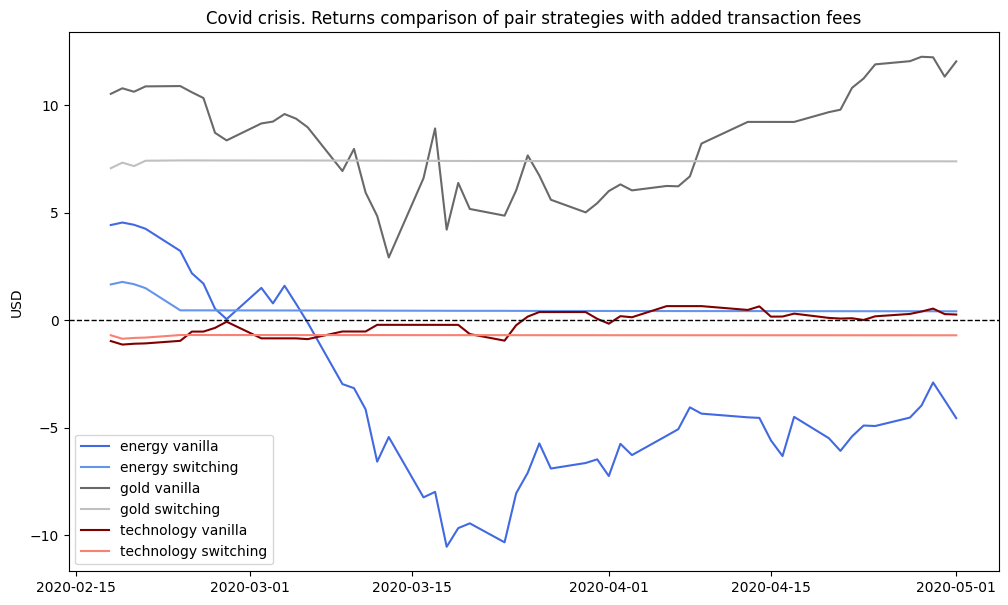

In [48]:
start_covid = '2020-02-15'
end_covid = '2020-05-01'

plt.plot(cum_pnl_energy_no_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_energy_no_switch_shaved.loc[start_covid:end_covid], color='royalblue', label="energy vanilla")
plt.plot(cum_pnl_energy_with_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_energy_with_switch_shaved.loc[start_covid:end_covid], color='cornflowerblue', label="energy switching")
plt.plot(cum_pnl_gold_no_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_gold_no_switch_shaved.loc[start_covid:end_covid], color='dimgrey', label="gold vanilla")
plt.plot(cum_pnl_gold_with_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_gold_with_switch_shaved.loc[start_covid:end_covid], color='silver', label="gold switching")
plt.plot(cum_pnl_tech_no_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_tech_no_switch_shaved.loc[start_covid:end_covid], color='maroon', label="technology vanilla")
plt.plot(cum_pnl_tech_with_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_tech_with_switch_shaved.loc[start_covid:end_covid], color='salmon', label="technology switching")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Covid crisis. Returns comparison of pair strategies with added transaction fees")
plt.legend(loc="lower left")
plt.show()

In the graph above, the pair strategies with added volatility-based regime-switching indicator are plotted in light colors.
It can be seen that the regime-switching indicator turns off the trading for all three sectors, with the indicator for the Gold ETFs strategy anticipating by a few days the other two.
This means the crisis regime has been timely captured by the indicator, which renders the strategies inactive for the whole crisis period.

Vanilla strategies for the Energy and Gold, on the other hand, experience wild swings in returns, with large drawdowns that send the Energy vanilla strategy deeply in the red.
The Technology vanilla strategy instead keeps on trading blithely, and it even realises a modest gain at the end of the period, notwithstanding the ongoing Covid crisis.
The Gold vanilla strategy also outperforms its regime-switching enhanced version, although the big drawdown it experiences certainly does not constitute a desirable side effect.

This again leaves the Energy sector as the one which benefits the most from the regime-switching indicator halting all trades during crises detectable by the presence high volatility.

In [49]:
def extractPercentage(vanilla, switch):
    return (switch - vanilla) / vanilla * 100

##### List evidence-based improvements to the regime-aware approach

As already mentioned previously within this section, the Energy sector pair strategy is the one which benefits the most from an added volatility based regime-switching indicator, so here we will summarise some of these improvements.

In [50]:
print(f"The improvement in cumulative PnL resulting from adopting the regime-aware approach amounts to {extractPercentage(5.2057,7.3274):.2f} % for the Energy pair.")

The improvement in cumulative PnL resulting from adopting the regime-aware approach amounts to 40.76 % for the Energy pair.


- Halting all trades during crisis periods allows the regime-aware approach to avoid losses due to the breakdown of the co-integration relation at the foundations of the pair strategy algorithm. This is reflected in cumulative returns improving by $40.76 \%$, going from $5.21$ for the vanilla strategy, to $7.33$ with the regime-switching enhancement.

In [51]:
print(f"The improvement in annualised Sharpe ratio resulting from adopting the regime-aware approach amounts to {extractPercentage(0.1805, 0.3713):.2f} % for the Energy pair.")

The improvement in annualised Sharpe ratio resulting from adopting the regime-aware approach amounts to 105.71 % for the Energy pair.


- The Sharpe ratio offers a measure of returns per unit of risk (the latter expressed as volatility).
Clearly the Energy sector is affected by volatility in the markets, so a regime-switching artifact based on volatility decisively helps in increasing the Sharpe ratio of the pair strategy by more than double ($105.71 \%$), from $0.18$ for the vanilla strategy, up to $0.37$.
Avoiding to enter trades during high-volatility periods for this sector minimises risk assumption.

In [52]:
print(f"The improvement in maximum drawdown resulting from adopting the regime-aware approach amounts to {extractPercentage(-264.1619, -140.3723):.2f} % for the Energy pair")

The improvement in maximum drawdown resulting from adopting the regime-aware approach amounts to -46.86 % for the Energy pair


- Maximum drawdown is mostly important from a psychological point of view, as traders and investors are naturally averse to big losses that keep going down.
Drawdowns are also deleterious in that they increase margins, and lead to stiffer capital requirements.
The pair strategy in the Energy sector sees a reduction in maximum drawdown of $-46.86 \%$, moving from a big trough of $-264 \%$ in the vanilla implementation, to a much reduced $-140 \%$ when the regime-switching indicator is enabled.

In [53]:
print(f"The improvement in number of trades resulting from adopting the regime-aware approach amounts to {extractPercentage(1054, 837):.2f} % for the Energy pair")
print(f"The improvement in winning rate resulting from adopting the regime-aware approach amounts to {extractPercentage(50.0949, 50.5376):.2f} % for the Energy pair")

The improvement in number of trades resulting from adopting the regime-aware approach amounts to -20.59 % for the Energy pair
The improvement in winning rate resulting from adopting the regime-aware approach amounts to 0.88 % for the Energy pair


- Secondary features like number of trades and ratio of those trades turning out to be profitable (winning ratio) are also improved when adopting the regime-aware approach within the Energy sector pair trading strategy.
The number of trades is reduced going from the vanilla strategy ($1054$ trades during 2017-22) to the enhanced one ($837$ trades) by $-20.59 \%$, stemming from the suspension of trading activities induced by the indicator during crisis periods.
A part from avoidance from entering likely losing trades, less trading activity in turn leads to savings in transaction fees.
In the same context, the winning ratio slightly increasing from $50.09 \%$ vanilla to $50.54 \%$ regime-aware - an overall $0.88 \%$ jump - translates to roughly 10 negative trades avoided in a 5 years period.
Mostly likely, these losing trades were avoided by halting trading during the Covid crisis period.